# Model

In [ ]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

In [ ]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

In [ ]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2),
                torch.randn(2, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

# Data

In [ ]:
import json

def load_data_from_json(json_data):
    processed_data = []
    for item in json_data:
        sentence = item["sentence"]
        tokens = [token["word"] for token in item["tokens"]]
        tags = [token["pos"] for token in item["tokens"]]
        processed_data.append((tokens, tags))
    return processed_data

with open("output-train.json", "r", encoding="utf-8") as f:
    train_json = json.load(f)

with open("output-val.json", "r", encoding="utf-8") as f:
    val_json = json.load(f)

with open("output-test.json", "r", encoding="utf-8") as f:
    test_json = json.load(f)

train_data = load_data_from_json(train_json)
val_data = load_data_from_json(val_json)
test_data = load_data_from_json(test_json)

In [ ]:
word_to_ix = {}
tag_to_ix = {}

for sentence, tags in train_data + val_data + test_data:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
    for tag in tags:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

START_TAG = "<START>"
STOP_TAG = "<STOP>"
tag_to_ix[START_TAG] = len(tag_to_ix)
tag_to_ix[STOP_TAG] = len(tag_to_ix)

word_to_ix["<UNK>"] = len(word_to_ix)


# Train

Epoch 1/10


Validating: 100%|██████████| 538/538 [00:12<00:00, 42.02it/s]


Epoch 1/10 - Training Loss: 17.5174, Validation Loss: 12.3589
Epoch 2/10


Validating: 100%|██████████| 538/538 [00:13<00:00, 39.28it/s]


Epoch 2/10 - Training Loss: 10.9096, Validation Loss: 10.5416
Epoch 3/10


Validating: 100%|██████████| 538/538 [00:14<00:00, 38.30it/s]


Epoch 3/10 - Training Loss: 9.6548, Validation Loss: 9.8033
Epoch 4/10


Validating: 100%|██████████| 538/538 [00:13<00:00, 39.28it/s]


Epoch 4/10 - Training Loss: 8.9446, Validation Loss: 9.2232
Epoch 5/10


Validating: 100%|██████████| 538/538 [00:13<00:00, 40.18it/s]


Epoch 5/10 - Training Loss: 8.4164, Validation Loss: 8.8124
Epoch 6/10


Validating: 100%|██████████| 538/538 [00:12<00:00, 41.51it/s]


Epoch 6/10 - Training Loss: 7.9429, Validation Loss: 8.4645
Epoch 7/10


Validating: 100%|██████████| 538/538 [00:15<00:00, 35.40it/s]


Epoch 7/10 - Training Loss: 7.5705, Validation Loss: 8.1781
Epoch 8/10


Validating: 100%|██████████| 538/538 [00:13<00:00, 39.22it/s]


Epoch 8/10 - Training Loss: 7.2392, Validation Loss: 7.9563
Epoch 9/10


Validating: 100%|██████████| 538/538 [00:14<00:00, 37.94it/s]


Epoch 9/10 - Training Loss: 6.9113, Validation Loss: 7.6933
Epoch 10/10


Validating: 100%|██████████| 538/538 [00:14<00:00, 37.83it/s]


Epoch 10/10 - Training Loss: 6.5869, Validation Loss: 7.5015
Total Training Time: 7371.68 seconds


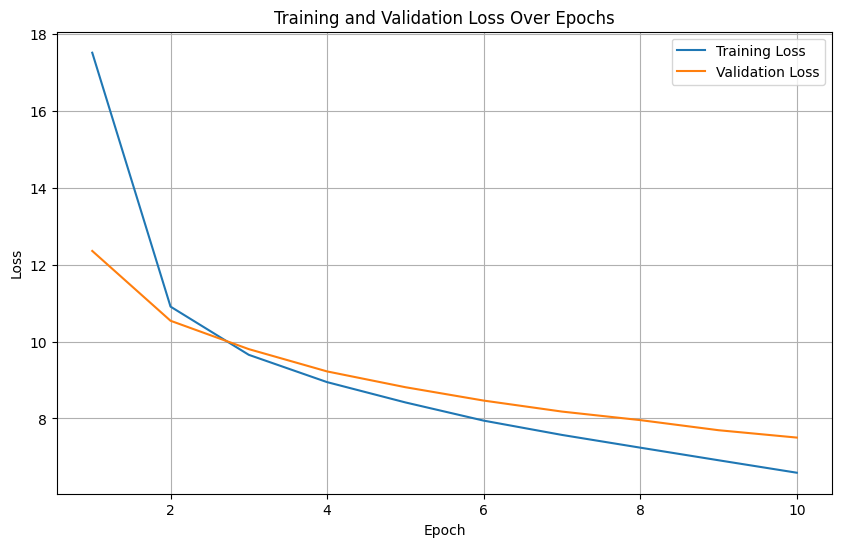

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

EMBEDDING_DIM = 5 ### 可调
HIDDEN_DIM = 4 ### 可调

model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4) ### 可调

epochs = 10 ### 可调
train_losses = []
val_losses = []

start_time = time.time()

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    model.train()
    total_train_loss = 0
    for sentence, tags in tqdm(train_data, desc="Training"):
        model.zero_grad()
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long)

        loss = model.neg_log_likelihood(sentence_in, targets)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_data)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for sentence, tags in tqdm(val_data, desc="Validating"):
            sentence_in = prepare_sequence(sentence, word_to_ix)
            targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long)

            val_loss = model.neg_log_likelihood(sentence_in, targets)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_data)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1}/{epochs} - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

end_time = time.time()
total_time = end_time - start_time
print(f"Total Training Time: {total_time:.2f} seconds")

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()

plt.grid()
plt.show()


# Evaluate

In [ ]:
model.eval()
test_results = []
with torch.no_grad():
    for sentence, tags in test_data:
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long)

        _, predictions = model(sentence_in)

        test_results.append((predictions, targets.tolist()))

for i, (pred, true) in enumerate(test_results[:10]):
    print(f"Sample {i + 1}:")
    print(f"Predicted Tags: {pred}")
    print(f"True Tags:      {true}")
    print()


Sample 1:
Predicted Tags: [11, 1, 0, 0, 1, 2, 0, 1, 2, 3, 3, 1, 10, 0, 10, 0, 1, 0, 1, 0, 1, 0, 1, 2, 1, 2, 0, 1, 2, 3, 9, 3, 4]
True Tags:      [11, 1, 0, 0, 1, 2, 0, 1, 2, 3, 3, 1, 10, 0, 10, 2, 1, 0, 1, 0, 1, 0, 1, 2, 1, 2, 0, 1, 2, 3, 9, 3, 4]

Sample 2:
Predicted Tags: [0, 1, 0, 0, 1, 1, 10, 12, 0, 2, 1, 2, 1, 2, 0, 1, 2, 1, 2, 3, 3, 4]
True Tags:      [0, 1, 0, 0, 1, 1, 10, 12, 12, 2, 1, 13, 1, 2, 0, 1, 2, 1, 2, 3, 3, 4]

Sample 3:
Predicted Tags: [0, 0, 1, 0, 1, 2, 3, 10, 8, 0, 1, 0, 0, 2, 3, 4]
True Tags:      [0, 0, 1, 9, 1, 2, 3, 10, 8, 0, 1, 0, 5, 2, 3, 4]

Sample 4:
Predicted Tags: [0, 1, 0, 1, 1, 4, 0, 5, 1, 2, 3, 3, 4]
True Tags:      [0, 1, 0, 1, 1, 12, 0, 5, 1, 2, 3, 3, 4]

Sample 5:
Predicted Tags: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 2, 3, 4]
True Tags:      [0, 1, 0, 1, 0, 1, 0, 1, 2, 1, 2, 3, 4]

Sample 6:
Predicted Tags: [0, 1, 0, 1, 0, 5, 4]
True Tags:      [0, 1, 0, 1, 13, 13, 4]

Sample 7:
Predicted Tags: [11, 1, 0, 10, 11, 1, 0, 1, 0, 1, 0, 1, 2, 1, 2, 3, 4]
True Tag

In [ ]:
# overall accuracy
correct = 0
total = 0

for pred, true in test_results:
    correct += sum([p == t for p, t in zip(pred, true)])
    total += len(true)

accuracy = correct / total
print(f"Overall Accuracy: {accuracy:.4%}")


Overall Accuracy: 89.7659%


In [ ]:
# Per-Class Metrics
from sklearn.metrics import classification_report

all_preds = []
all_trues = []

for pred, true in test_results:
    all_preds.extend(pred)
    all_trues.extend(true)

print("Classification Report:")
print(classification_report(all_trues, all_preds, zero_division=0))


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.90      4216
           1       0.96      0.98      0.97      3556
           2       0.87      0.89      0.88      1593
           3       0.94      0.86      0.90      1095
           4       0.98      0.98      0.98      1225
           5       0.66      0.87      0.75       397
           6       0.87      0.73      0.79        85
           7       0.81      0.60      0.69        35
           8       0.68      0.48      0.56       123
           9       0.71      0.28      0.40       148
          10       0.95      0.85      0.90       143
          11       0.79      0.48      0.60        95
          12       0.80      0.02      0.05       166
          13       0.61      0.22      0.32       195
          14       0.00      0.00      0.00         2

    accuracy                           0.90     13074
   macro avg       0.77      0.61      0.65     13074
wei

In [ ]:
# sentence-level accuracy
correct_sentences = 0
total_sentences = len(test_results)

for pred, true in test_results:
    if pred == true:
        correct_sentences += 1

sentence_accuracy = correct_sentences / total_sentences
print(f"Sentence-Level Accuracy: {sentence_accuracy:.4%}")


Sentence-Level Accuracy: 17.3077%


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Macro & Micro
macro_metrics = precision_recall_fscore_support(all_trues, all_preds, average="macro", zero_division=0)
micro_metrics = precision_recall_fscore_support(all_trues, all_preds, average="micro", zero_division=0)

print(f"Macro Precision: {macro_metrics[0]:.4f}, Recall: {macro_metrics[1]:.4f}, F1-Score: {macro_metrics[2]:.4f}")
print(f"Micro Precision: {micro_metrics[0]:.4f}, Recall: {micro_metrics[1]:.4f}, F1-Score: {micro_metrics[2]:.4f}")


Macro Precision: 0.7670, Recall: 0.6124, F1-Score: 0.6467
Micro Precision: 0.8977, Recall: 0.8977, F1-Score: 0.8977


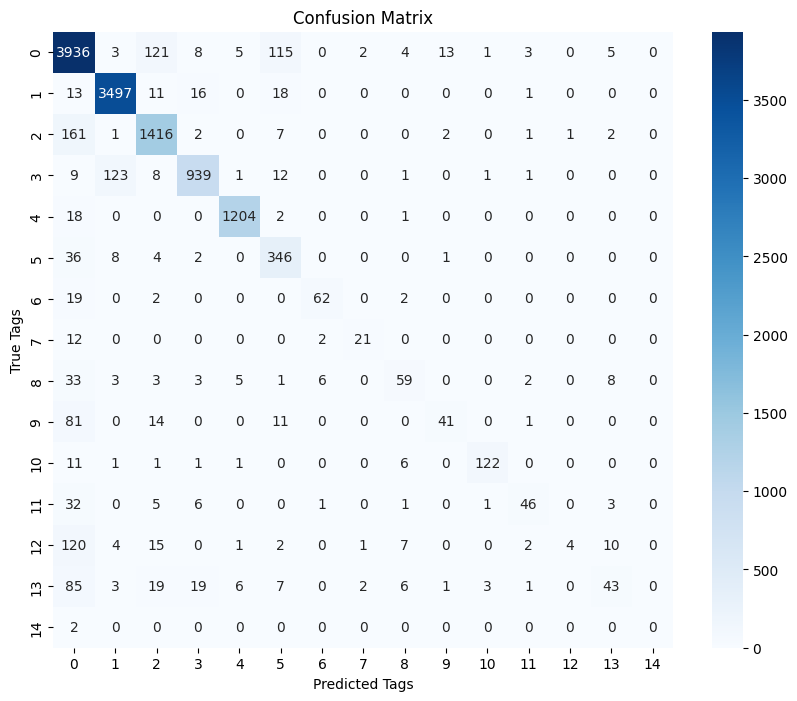

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# confusion matrix
conf_matrix = confusion_matrix(all_trues, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Tags")
plt.ylabel("True Tags")
plt.title("Confusion Matrix")
plt.show()


建议指标选择

初步评估：优先使用整体准确率 (Overall Accuracy) 和分类报告 (Per-Class Metrics)。

高精度任务：关注每类标签的 F1 分数，尤其是少见标签。

高要求评估：使用句子级准确率 (Sentence-Level Accuracy)。

错误分析：使用混淆矩阵 (Confusion Matrix) 查找错误分布。

In [ ]:
import pickle

# save
with open("test_results.pkl", "wb") as f:
    pickle.dump(test_results, f)

print("test_results has been saved to test_results.pkl")


test_results has been saved to test_results.pkl
